# Component 2a: Vector Quantization Benchmark

This component benchmarks Vector Quantization (VQ) for approximate nearest neighbor search.

**Experiments:**
1. Accuracy vs Efficiency: Vary `n_probes` to study recall-efficiency trade-off
2. Scaling with N: Measure build/query time as dataset size increases
3. Scaling with Dimensionality: Measure performance across different vector dimensions

In [15]:
import sys
import os
import time

sys.path.append("Components")
from vector_quantization import fit_kmeans, vq_query
from evaluation import compute_recall_at_k, compute_ndcg_at_k

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances

# Reproducibility
np.random.seed(42)
np.set_printoptions(precision=4, suppress=True)

# Load precomputed document vectors and metadata
doc_vectors = np.load("Data/processed/doc_vectors_w2v.npy")
metadata = pd.read_csv("Data/processed/doc_metadata.csv")

print(f"Vectors shape: {doc_vectors.shape}")
print(f"Metadata records: {metadata.shape[0]}")
print("✓ Evaluation metrics loaded from Components/evaluation.py (Manning et al., Chapter 8)")

Vectors shape: (17830, 200)
Metadata records: 17830
✓ Evaluation metrics loaded from Components/evaluation.py (Manning et al., Chapter 8)


## Experiment 1: Accuracy vs Efficiency (vary n_probes)

## Experiment Parameters

In [16]:
# Experiment parameters
TOP_K = 10
N_QUERIES = 50
C = 200  # number of clusters (roughly sqrt(18k) as suggested in lecture slides)

# Best n_probes from Experiment 1 (used in Experiments 2-3)
BEST_N_PROBES = 5

## Experiment 1: Accuracy vs Efficiency

In [17]:
# Random query set
query_indices = np.random.choice(len(doc_vectors), N_QUERIES, replace=False)

# Ground truth: exact k-NN with brute-force L2 (on L2-normalized vectors)
exact_results = {}
for qi in query_indices:
    dists = euclidean_distances(doc_vectors[qi:qi+1], doc_vectors).ravel()
    exact_results[qi] = np.argsort(dists)[:TOP_K]

# Fit KMeans once on the full dataset
print("Fitting KMeans for vector quantization...")
kmeans, assignments = fit_kmeans(doc_vectors, k=C)

results = []

# We sweep n_probes to study the recall–efficiency trade-off
for n_probes in [1, 2, 5, 10, 20]:
    print(f"Testing n_probes = {n_probes}")
    recalls = []
    ndcgs = []
    candidate_ratios = []
    query_times = []
    
    for qi in query_indices:
        # Time the approximate query
        t0 = time.perf_counter()
        indices, _ = vq_query(
            doc_vectors[qi],
            doc_vectors,
            kmeans,
            assignments,
            top_n=TOP_K,
            n_probes=n_probes,
        )
        query_times.append(time.perf_counter() - t0)
        
        # Effectiveness metrics (relevant set = exact top-k)
        recalls.append(compute_recall_at_k(indices, exact_results[qi], TOP_K))
        ndcgs.append(compute_ndcg_at_k(indices, exact_results[qi], TOP_K))
        
        # Candidate ratio = fraction of corpus that we re-rank
        cluster_ids = np.argsort(
            euclidean_distances(
                doc_vectors[qi:qi+1],
                kmeans.cluster_centers_
            ).ravel()
        )[:n_probes]
        
        n_candidates = np.sum(np.isin(assignments, cluster_ids))
        candidate_ratios.append(n_candidates / len(doc_vectors))
    
    results.append({
        "method": "VQ",
        "n_probes": n_probes,
        "c_clusters": C,
        "recall_at_k": float(np.mean(recalls)),
        "ndcg_at_k": float(np.mean(ndcgs)),
        "candidate_ratio": float(np.mean(candidate_ratios)),
        "query_time": float(np.mean(query_times)),
        "N": len(doc_vectors),
        "dim": doc_vectors.shape[1],
    })

df_exp1 = pd.DataFrame(results)
print("\n=== Experiment 1: Accuracy vs Efficiency (VQ) ===")
display(df_exp1)

Fitting KMeans for vector quantization...
Testing n_probes = 1
Testing n_probes = 2
Testing n_probes = 5
Testing n_probes = 10
Testing n_probes = 20

=== Experiment 1: Accuracy vs Efficiency (VQ) ===


,method,n_probes,c_clusters,recall_at_k,ndcg_at_k,candidate_ratio,query_time,N,dim
0,VQ,1,200,0.380,0.526131,0.006369,0.000369,17830,200
1,VQ,2,200,0.548,0.671039,0.012735,0.000479,17830,200
2,VQ,5,200,0.762,0.837849,0.031724,0.000564,17830,200
3,VQ,10,200,0.904,0.937242,0.064658,0.000774,17830,200
4,VQ,20,200,0.976,0.984404,0.129421,0.001140,17830,200


## Experiment 2: Scaling with N

In [18]:
N_LIST = [1000, 2000, 5000, 10000, min(20000, len(doc_vectors))]
TEST_QUERIES = 10

scaling_results = []

for N in N_LIST:
    print(f"Testing N = {N}")
    X = doc_vectors[:N]
    test_idx = np.random.choice(N, TEST_QUERIES, replace=False)
    
    # Keep the number of clusters fixed at C where possible
    # We fix C=200 clusters for comparability; for very small N we cap C at N
    n_clusters = min(C, N)  # cannot have more clusters than points
    
    t0 = time.perf_counter()
    kmeans_N, assignments_N = fit_kmeans(X, k=n_clusters)
    build_t = time.perf_counter() - t0
    
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        vq_query(
            X[qi],
            X,
            kmeans_N,
            assignments_N,
            top_n=TOP_K,
            n_probes=BEST_N_PROBES,
        )
        q_times.append(time.perf_counter() - t1)
    
    scaling_results.append({
        "method": "VQ",
        "N": N,
        "dim": X.shape[1],
        "c_clusters": n_clusters,
        "build_time": build_t,
        "query_time": float(np.mean(q_times)),
    })

df_exp2 = pd.DataFrame(scaling_results)
print("\n=== Experiment 2: Scaling with N ===")
display(df_exp2)

Testing N = 1000
Testing N = 2000
Testing N = 5000
Testing N = 10000
Testing N = 17830

=== Experiment 2: Scaling with N ===


,method,N,dim,c_clusters,build_time,query_time
0,VQ,1000,200,200,0.074933,0.000272
1,VQ,2000,200,200,0.138277,0.000306
2,VQ,5000,200,200,0.333886,0.000406
3,VQ,10000,200,200,0.711724,0.000453
4,VQ,17830,200,200,1.256865,0.000593


## Experiment 3: Scaling with Dimensionality

In [19]:
DIM_LIST = [50, 100, 200]
N_SAMPLE = 10000
TEST_QUERIES = 10

dim_results = []
X_sample = doc_vectors[:N_SAMPLE]

# We keep C=200 and vary only the dimensionality
for d in DIM_LIST:
    print(f"Testing d = {d}")
    X = X_sample[:, :d]
    test_idx = np.random.choice(N_SAMPLE, TEST_QUERIES, replace=False)
    
    t0 = time.perf_counter()
    kmeans_d, assignments_d = fit_kmeans(X, k=C)
    build_t = time.perf_counter() - t0
    
    q_times = []
    for qi in test_idx:
        t1 = time.perf_counter()
        vq_query(
            X[qi],
            X,
            kmeans_d,
            assignments_d,
            top_n=TOP_K,
            n_probes=BEST_N_PROBES,
        )
        q_times.append(time.perf_counter() - t1)
    
    dim_results.append({
        "method": "VQ",
        "N": N_SAMPLE,
        "dim": d,
        "c_clusters": C,
        "build_time": build_t,
        "query_time": float(np.mean(q_times)),
    })

df_exp3 = pd.DataFrame(dim_results)
print("\n=== Experiment 3: Scaling with Dimensionality ===")
display(df_exp3)

Testing d = 50
Testing d = 100
Testing d = 200

=== Experiment 3: Scaling with Dimensionality ===


,method,N,dim,c_clusters,build_time,query_time
0,VQ,10000,50,200,0.177023,0.000329
1,VQ,10000,100,200,0.305550,0.000368
2,VQ,10000,200,200,0.648120,0.000389


## Save Results

In [20]:
results_dir = "Data/results"
os.makedirs(results_dir, exist_ok=True)

df_exp1.to_csv(f"{results_dir}/vq_accuracy_efficiency.csv", index=False)
df_exp2.to_csv(f"{results_dir}/vq_scaling_N.csv", index=False)
df_exp3.to_csv(f"{results_dir}/vq_scaling_dim.csv", index=False)

print(" All VQ results saved to", results_dir)

 All VQ results saved to Data/results


## Visualization

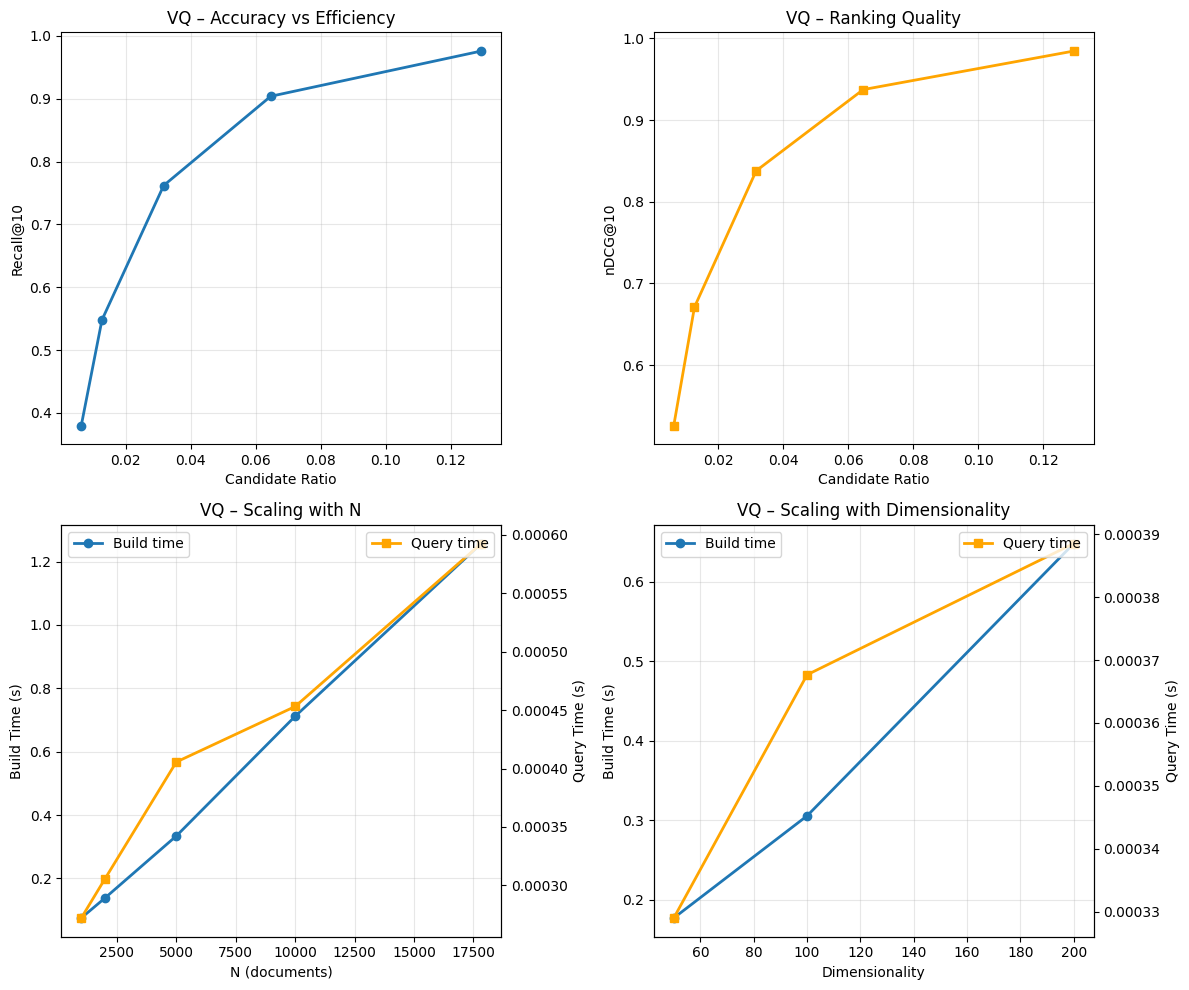

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# (1) Recall vs Candidate Ratio
axes[0, 0].plot(
    df_exp1["candidate_ratio"],
    df_exp1["recall_at_k"],
    "o-",
    linewidth=2,
)
axes[0, 0].set(
    xlabel="Candidate Ratio",
    ylabel="Recall@10",
    title="VQ – Accuracy vs Efficiency",
)
axes[0, 0].grid(alpha=0.3)

# (2) nDCG vs Candidate Ratio
axes[0, 1].plot(
    df_exp1["candidate_ratio"],
    df_exp1["ndcg_at_k"],
    "s-",
    linewidth=2,
    color='orange'
)
axes[0, 1].set(
    xlabel="Candidate Ratio",
    ylabel="nDCG@10",
    title="VQ – Ranking Quality",
)
axes[0, 1].grid(alpha=0.3)

# (3) Scaling with N
ax2 = axes[1, 0]
ax2.plot(
    df_exp2["N"],
    df_exp2["build_time"],
    "o-",
    label="Build time",
    linewidth=2,
)
ax2_twin = ax2.twinx()
ax2_twin.plot(
    df_exp2["N"],
    df_exp2["query_time"],
    "s-",
    label="Query time",
    linewidth=2,
    color='orange'
)
ax2.set(
    xlabel="N (documents)",
    ylabel="Build Time (s)",
    title="VQ – Scaling with N",
)
ax2_twin.set_ylabel("Query Time (s)")
ax2.legend(loc="upper left")
ax2_twin.legend(loc="upper right")
ax2.grid(alpha=0.3)

# (4) Scaling with dimensionality
ax3 = axes[1, 1]
ax3.plot(
    df_exp3["dim"],
    df_exp3["build_time"],
    "o-",
    label="Build time",
    linewidth=2,
)
ax3_twin = ax3.twinx()
ax3_twin.plot(
    df_exp3["dim"],
    df_exp3["query_time"],
    "s-",
    label="Query time",
    linewidth=2,
    color='orange'
)
ax3.set(
    xlabel="Dimensionality",
    ylabel="Build Time (s)",
    title="VQ – Scaling with Dimensionality",
)
ax3_twin.set_ylabel("Query Time (s)")
ax3.legend(loc="upper left")
ax3_twin.legend(loc="upper right")
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(
    f"{results_dir}/vq_benchmark_summary.png",
    dpi=150,
    bbox_inches="tight",
)
plt.show()